In [ ]:
!pip install transformers==4.28.0
!pip install --upgrade accelerate

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from transformers import AutoTokenizer, OpenAIGPTForSequenceClassification, Trainer, TrainingArguments
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
torch.cuda.is_available()

True

In [4]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


In [7]:
train_dataset = pd.read_csv('datasets/train_level_a.csv')
train_dataset

,id,tweet,subtask_a
0,86426,@USER She should ask a few native Americans wh...,OFF
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,16820,Amazon is investigating Chinese employees who ...,NOT
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT
...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT
13237,82921,@USER And why report this garbage. We don't g...,OFF
13238,27429,@USER Pussy,OFF


In [8]:
le = LabelEncoder()

train_texts = train_dataset["tweet"].tolist()
train_labels = le.fit_transform(train_dataset["subtask_a"]).tolist()

In [9]:
tokenizer = AutoTokenizer.from_pretrained("openai-gpt")
model = OpenAIGPTForSequenceClassification.from_pretrained("openai-gpt")

Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))
    
model.config.pad_token_id = tokenizer.pad_token_id

Using pad_token, but it is not set yet.


In [11]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [13]:
train_dataset = CustomDataset(train_encodings, train_labels)

In [14]:
training_args = TrainingArguments(
    output_dir="models/GPT",
    num_train_epochs=1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

In [15]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.548600
1000,0.483900
1500,0.474800


TrainOutput(global_step=1655, training_loss=0.49954948310045316, metrics={'train_runtime': 483.0667, 'train_samples_per_second': 27.408, 'train_steps_per_second': 3.426, 'total_flos': 1148664268800000.0, 'train_loss': 0.49954948310045316, 'epoch': 1.0})

In [16]:
test_dataset = pd.read_csv('datasets/test_level_a.csv')
test_dataset

,id,tweet,label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF
...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT


In [17]:
test_texts = test_dataset["tweet"].tolist()
test_labels = le.fit_transform(test_dataset["label"]).tolist()

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'NOT': 0, 'OFF': 1}


In [19]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [20]:
test_dataset = CustomDataset(test_encodings, test_labels)

In [21]:
predictions = trainer.predict(test_dataset)

In [22]:
y_pred = np.argmax(predictions[0], axis=1)
y_true = test_labels

In [27]:
def plot_conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    class_names = le.classes_ # name  of classes
    fig, ax = plt.subplots()
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g', ax=ax)
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels');

              precision    recall  f1-score   support

         NOT     0.8826    0.9097    0.8959       620
         OFF     0.7466    0.6875    0.7158       240

    accuracy                         0.8477       860
   macro avg     0.8146    0.7986    0.8059       860
weighted avg     0.8447    0.8477    0.8457       860


accuracy: 0.8476744186046512
macro F1: 0.8058921535012982
weighted F1: 0.8456847869330629



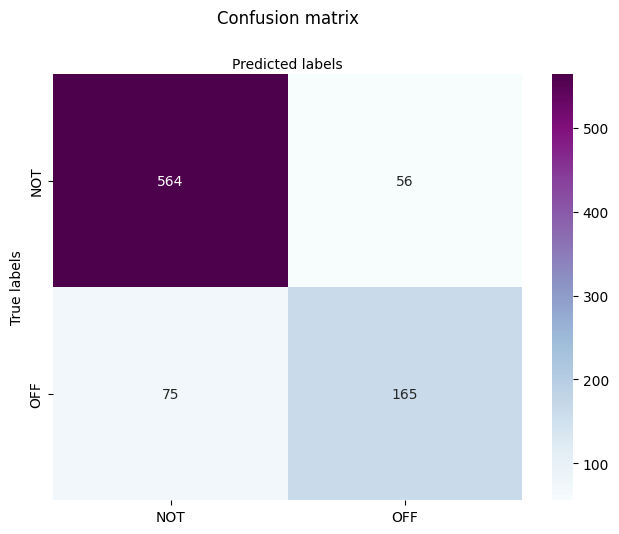

In [28]:
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))
print()
print("accuracy:", accuracy_score(y_true, y_pred))
print("macro F1:", f1_score(y_true, y_pred, average='macro'))
print("weighted F1:", f1_score(y_true, y_pred, average='weighted'))
print()
plot_conf_matrix(y_true, y_pred)

In [34]:
true_labels = le.inverse_transform(y_true)
gpt_labels = le.inverse_transform(y_pred)

In [35]:
predictions_file = pd.read_csv('predictions.csv')
predictions_file

,id,tweet,true_label,bert_label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,NOT
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,NOT
...,...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,NOT
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT,OFF


In [37]:
predictions_file['gpt_label'] = gpt_labels
predictions_file

,id,tweet,true_label,bert_label,gpt_label
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,NOT,OFF
1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,NOT,NOT
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,NOT,NOT
3,13876,#Watching #Boomer getting the news that she is...,NOT,NOT,NOT
4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,NOT,NOT
...,...,...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,OFF,NOT,NOT
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,NOT,NOT,NOT
857,67018,3 people just unfollowed me for talking about ...,OFF,OFF,OFF
858,50665,#WednesdayWisdom Antifa calls the right fascis...,NOT,OFF,NOT


In [38]:
predictions_file.to_csv('predictions.csv', index=False)